In [60]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## test

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_and_crop(image, mask, class_id, target_size=(256, 256)):
    """
    이미지와 마스크에서 특정 클래스를 크롭하고, 크롭된 이미지를 타겟 크기로 리사이즈합니다.

    Parameters:
    image (np.array): 원본 이미지.
    mask (np.array): 예측된 마스크.
    class_id (int): 크롭할 클래스의 ID (예: 1은 상의, 2는 하의).
    target_size (tuple): 리사이즈할 타겟 크기 (기본값: (256, 256)).

    Returns:
    cropped_image (np.array): 크롭된 이미지.
    """
    # 해당 클래스의 마스크 추출
    class_mask = (mask == class_id).astype(np.uint8)

    # 노이즈 제거를 위한 모폴로지 연산 (열기 연산)
    kernel = np.ones((5, 5), np.uint8)
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel)

    # 연결된 컴포넌트를 찾아 경계 상자 계산
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(class_mask, connectivity=8)

    # 가장 큰 연결 컴포넌트의 경계 상자 추출 (0번 레이블은 배경이므로 제외)
    if num_labels > 1:  # Ensure there are connected components detected
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        x, y, w, h = stats[largest_component, cv2.CC_STAT_LEFT], stats[largest_component, cv2.CC_STAT_TOP], stats[largest_component, cv2.CC_STAT_WIDTH], stats[largest_component, cv2.CC_STAT_HEIGHT]

        # 원본 이미지에서 해당 영역 크롭
        cropped_image = image[y:y+h, x:x+w]

        # 마스크된 원본 이미지 생성
        masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=class_mask[y:y+h, x:x+w])

        # 검정 배경 이미지 생성
        black_background = np.zeros((*target_size, 3), dtype=np.uint8)

        # 타겟 크기로 리사이즈
        resized_image = cv2.resize(masked_image, target_size, interpolation=cv2.INTER_LINEAR)

        # 중앙에 크롭된 이미지 배치
        black_background[
            (target_size[0] - resized_image.shape[0]) // 2 : (target_size[0] + resized_image.shape[0]) // 2,
            (target_size[1] - resized_image.shape[1]) // 2 : (target_size[1] + resized_image.shape[1]) // 2
        ] = resized_image

        return black_background
    else:
        return np.zeros((*target_size, 3), dtype=np.uint8)  # Return an empty image if no components are found

def preprocess_image(image, target_size=(256, 256)):
    """
    원본 이미지의 비율을 유지하면서 타겟 크기로 리사이즈합니다.

    Parameters:
    image (np.array): 원본 이미지.
    target_size (tuple): 리사이즈할 타겟 크기 (기본값: (256, 256)).

    Returns:
    resized_image (np.array): 리사이즈된 이미지.
    """
    # 원본 이미지 크기
    h, w, _ = image.shape

    # 타겟 크기
    target_h, target_w = target_size

    # 비율 유지하여 리사이즈
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # 검정 배경 이미지 생성
    black_background = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # 중앙에 리사이즈된 이미지 배치
    black_background[
        (target_h - new_h) // 2 : (target_h + new_h) // 2,
        (target_w - new_w) // 2 : (target_w + new_w) // 2
    ] = resized_image

    return black_background

def crop_upper_clothing(image_path, model_path='/content/gdrive/MyDrive/Deep learning/model_epoch_11.h5', target_size=(256, 256)):
    """
    이미지 경로를 받아와서 모델로 상의를 크롭한 뒤 검정 배경에 붙인 이미지를 반환하고 저장합니다.

    Parameters:
    image_path (str): 입력 이미지 경로.
    model_path (str): 모델 파일 경로 (기본값: 'model_epoch_11.h5').
    target_size (tuple): 리사이즈할 타겟 크기 (기본값: (256, 256)).

    Returns:
    upper_crop (np.array), preprocessed_image (np.array): 크롭된 상의 이미지와 전처리된 입력 이미지.
    """
    # Load the model
    model = load_model(model_path)

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image for prediction
    preprocessed_image = preprocess_image(image, target_size)
    input_image = np.expand_dims(preprocessed_image, axis=0)

    # Make prediction
    predicted_mask = model.predict(input_image)
    predicted_mask = np.argmax(predicted_mask, axis=-1)[0]

    # 상의 크롭
    upper_crop = extract_and_crop(image, predicted_mask, class_id=1, target_size=target_size)

    # Save the cropped image
    output_path = 'cropped_upper_clothing.png'
    cv2.imwrite(output_path, cv2.cvtColor(upper_crop, cv2.COLOR_RGB2BGR))

    return upper_crop, preprocessed_image


1/1 [==============================] - 2s 2s/step


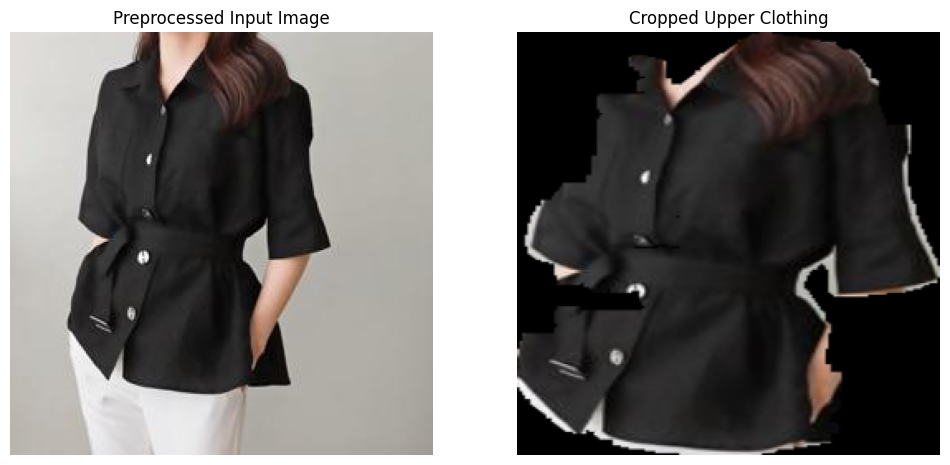

In [62]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test5.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test5_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.


### 모델 예측

In [63]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
# h5 파일 로드
style = tf.keras.models.load_model('/content/gdrive/MyDrive/Deep learning/style.h5')
color = tf.keras.models.load_model('/content/gdrive/MyDrive/Deep learning/color.h5')

# 입력 이미지 데이터가 단일 이미지라면:
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')

1/1 [==============================] - 2s 2s/step
style class: [2]
color class: [10]


test1

1/1 [==============================] - 2s 2s/step


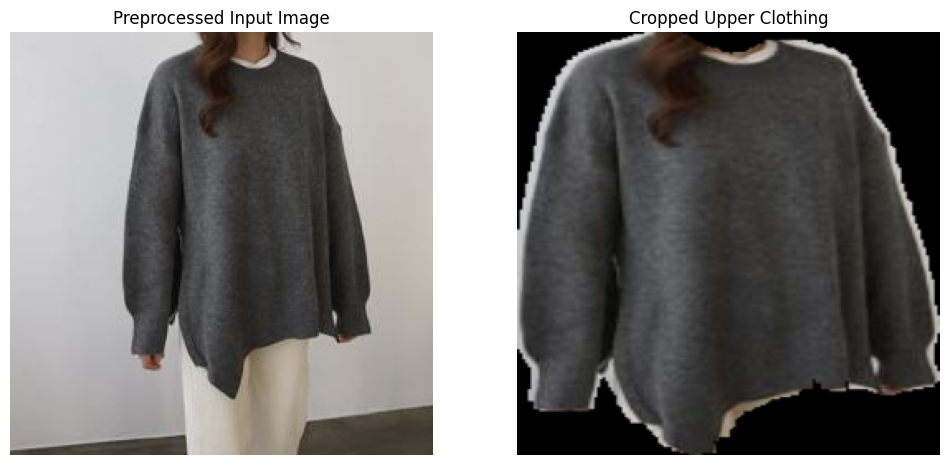

1/1 [==============================] - 1s 947ms/step
style class: [0]
color class: [10]


In [64]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test1.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test1_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')

test2

1/1 [==============================] - 2s 2s/step


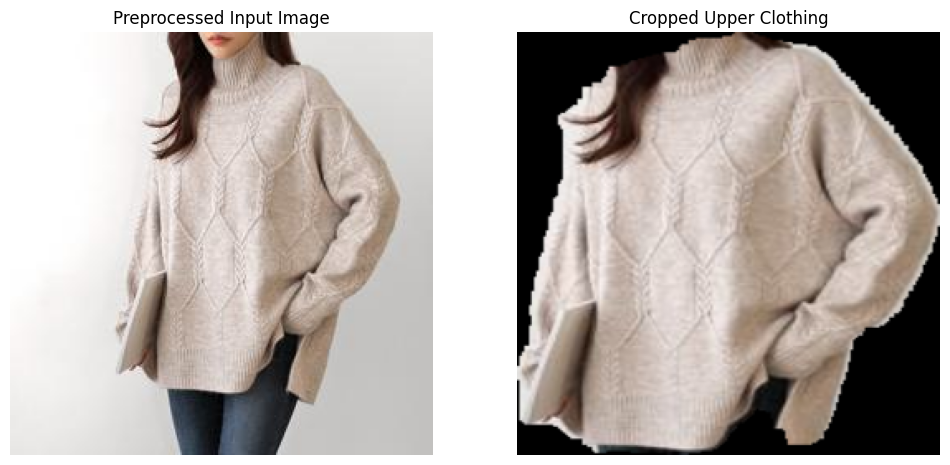

1/1 [==============================] - 2s 2s/step
style class: [0]
color class: [10]


In [65]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test2.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test2_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')


test3

1/1 [==============================] - 2s 2s/step


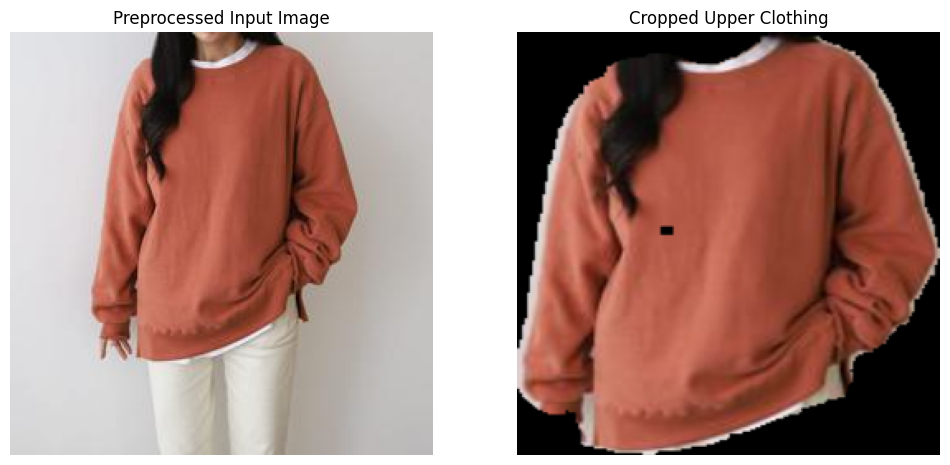

1/1 [==============================] - 1s 944ms/step
style class: [2]
color class: [9]


In [66]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test3.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test3_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')


test4

1/1 [==============================] - 3s 3s/step


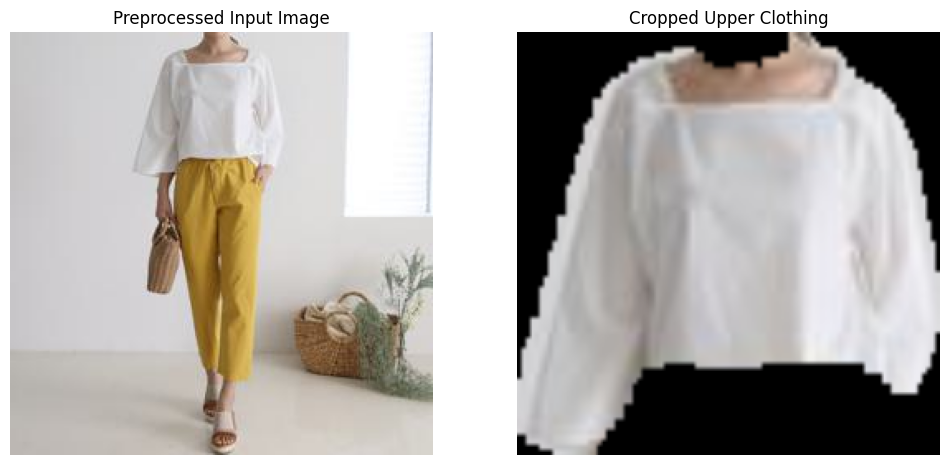

1/1 [==============================] - 1s 950ms/step
style class: [0]
color class: [20]


In [67]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test4.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test4_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')


test5

1/1 [==============================] - 2s 2s/step


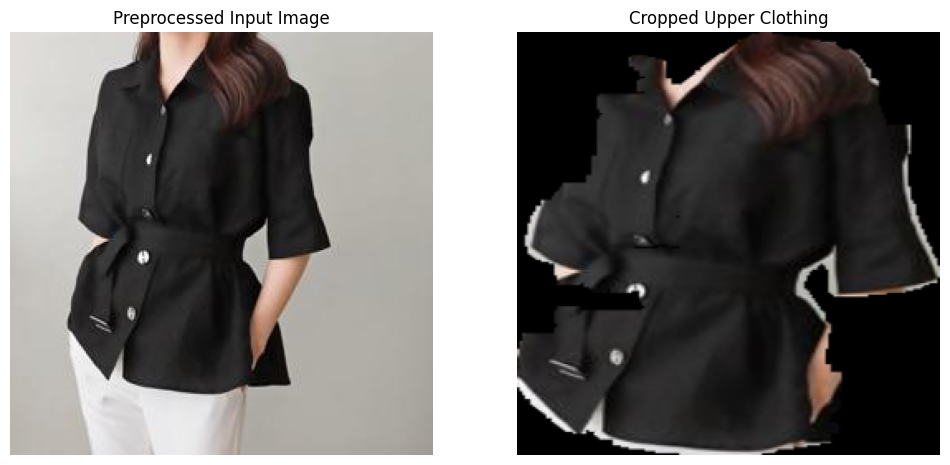

1/1 [==============================] - 1s 963ms/step
style class: [2]
color class: [10]


In [68]:

# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test5.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test5_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')
